In [2]:
# imports
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from sklearn.metrics import accuracy_score, confusion_matrix
from pathlib import Path
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("..") # not good
from tools.data import load_data_simc_v2, load_data_radioml_v1

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"


2023-05-08 00:28:02.248211: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 00:28:02.449087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 00:28:03.158788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-08 00:28:05.197711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

## Util functions

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading

In [4]:
# Constants
frames_per_mod = 30_000
snrs = list(range(0, 30))
MIXED_v2_0_30 = "/development/data/Mixed_V2/train_data_SIMC1_SNR_mixed_0-30_30k/"
# snrs = list(range(-30, 30))
# MIXED_v2_min_30_30 = "/development/data/Mixed_V2/mixed_v2_-30-30_30k/"
TRAIN_DATA_DIR = MIXED_v2_0_30

MODEL_DATA_TYPE = np.float32

SEED = 123456
set_seed(SEED)

In [6]:
# Loading itself
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

# labels, data = np.load("labels_mixed_V2_-30_30_30k.npy"), np.load("data_mixed_V2_-30_30_30k.npy")
labels, data = np.load("labels_mixed_V2_0_30_30k.npy"), np.load("data_mixed_V2_0_30_30k.npy")
# labels, data = load_data_simc_v2(classes=modulations, path=Path(TRAIN_DATA_DIR), model_dtype=MODEL_DATA_TYPE, frames_per_mod=frames_per_mod)
print(modulations)
print(labels.shape)
print(data.shape)

['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(330000,)
(330000, 1, 1024, 2)


In [7]:
# np.save("labels_mixed_V2_-30_30_30k.npy", labels)
# np.save("data_mixed_V2_-30_30_30k.npy", data)

In [8]:
# Data Ssplitting
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)                # 80% - Train
n_validation = int(0.1 * DS_SIZE)           # 10% - Validation
n_test = DS_SIZE - n_train - n_validation   # 10% - Test

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)

train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [9]:
# Should save some memory
del data
del labels

## Model creation
#### Parts of Encoder

Some utilities for final model


In [10]:
from typing import List
from dataclasses import dataclass

@dataclass
class ConvolutionConfiguration:
    output_channels: List[int]
    kernel_sizes: List[int]
    paddings: List[str]
    max_pool_sizes: List[int]

@dataclass
class DenseConfiguration:
    sizes: List[int]

Model parts

In [11]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

### Model
Model constists of a CNNn -> b EncoderLayers -> c Dense layers

In [12]:
def create_model_cnn(
    cnn_conf: ConvolutionConfiguration,
    dense_conf: DenseConfiguration,
    avg_size: int = 32,
    *args, 
    **kwargs
):
    InputLayer = keras.Input(shape=(1, 1024, 2))
    assert (
        len(cnn_conf.output_channels)
        == len(cnn_conf.kernel_sizes)
        == len(cnn_conf.paddings)
        == len(cnn_conf.max_pool_sizes)
    )
    N_CNNs = len(cnn_conf.output_channels)
    assert N_CNNs > 0

    CNN1 = layers.Conv2D(
        cnn_conf.output_channels[0],
        (1, cnn_conf.kernel_sizes[0]),
        padding=cnn_conf.paddings[0],
        name="CNN1_",
    )(InputLayer)
    model_layers = [CNN1]
    model_layers.append(CustomBatchNorm(name="BN1_")(model_layers[-1]))
    if cnn_conf.max_pool_sizes[0] != 1:
        model_layers.append(
            layers.MaxPool2D(pool_size=(1, cnn_conf.max_pool_sizes[0]), strides=(1, 2), name=f"MAX_POOL_1_")(
                model_layers[-1]
            )
        )
    # model_layers.append(CustomBatchNorm(name="BN1_")(model_layers[-1]))
    model_layers.append(layers.ReLU(name="CNN_RELU1_")(model_layers[-1]))

    for i in range(1, N_CNNs):
        model_layers.append(
            layers.Conv2D(
                cnn_conf.output_channels[i],
                (1, cnn_conf.kernel_sizes[i]),
                padding=cnn_conf.paddings[i],
                name=f"CNN{i+1}_",
            )(model_layers[-1])
        )
        model_layers.append(CustomBatchNorm(name=f"BN{i+1}_")(model_layers[-1]))
        if cnn_conf.max_pool_sizes[i] != 1:
            model_layers.append(
                layers.MaxPool2D(
                    pool_size=(1, cnn_conf.max_pool_sizes[i]),
                    strides=(1, 2),
                    name=f"MAX_POOL_{i+1}_",
                )(model_layers[-1])
            )
        # model_layers.append(CustomBatchNorm(name=f"BN{i+1}_")(model_layers[-1]))
        model_layers.append(layers.ReLU(name=f"CNN_RELU{i+1}_")(model_layers[-1]))

    model_layers.append(layers.AveragePooling2D((1, avg_size), name="AVG1_")(model_layers[-1]))

    model_layers.append(layers.Flatten(name="FLT1_")(model_layers[-1]))

    N_Dense = len(dense_conf.sizes)

    if N_Dense > 0:
        model_layers.append(layers.Dense(dense_conf.sizes[0], name="FC1_")(model_layers[-1]))
        model_layers.append(layers.ReLU(name="FC_RELU1_")(model_layers[-1]))

        for i in range(1, N_Dense):
            model_layers.append(
                layers.Dense(dense_conf.sizes[i], name=f"FC{i+1}_")(model_layers[-1])
            )
            model_layers.append(layers.ReLU(name=f"FC_RELU{i+1}_")(model_layers[-1]))

    model_layers.append(layers.Dense(len(modulations), name=f"FC_{N_Dense+1}_")(model_layers[-1]))
    SoftMax = layers.Softmax()(model_layers[-1])
    Output = layers.Flatten()(SoftMax)

    # if args and isinstance(args[0], str):
    #     model = keras.Model(inputs=[InputLayer], outputs=[Output], name=args[0])
    # else:
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

Test code above

In [13]:
model = create_model_cnn(
    ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192], kernel_sizes=[8, 8, 8, 8, 8, 8], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]),
    DenseConfiguration(sizes=[])
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 512, 32)        0         
                                                                 
 CNN_RELU1_ (ReLU)           (None, 1, 512, 32)        0         
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        12336     
                                                                 
 BN2_ (CustomBatchNorm)      (None, 1, 512, 48)        192   

2023-05-08 00:28:55.109354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 00:28:55.109630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 00:28:55.109775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### List of models we're interested at

In [19]:
default_cnn_conf = ConvolutionConfiguration(
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[2, 2, 2, 2, 2, 1],
)
default_dense_conf = DenseConfiguration(sizes=[])
default_avg_size = 32

configs = [
    [default_cnn_conf, default_dense_conf, default_avg_size, "Default_medium"],
    # Different kernel sizes
    # [ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192], kernel_sizes=[17, 17, 17, 17, 17, 17], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "k=17"],
    # [ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192], kernel_sizes=[33, 33, 33, 33, 33, 33], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "k=33"],
    # [ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192], kernel_sizes=[65, 65, 65, 65, 65, 65], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "k=65"],
    
    # Different Width of encoder layers
    # [ConvolutionConfiguration(output_channels=[16, 16, 32, 32, 64, 64], kernel_sizes=[8, 8, 8, 8, 8, 8], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "output_channels=[16, 16, 32, 32, 64, 64]"],
    # [ConvolutionConfiguration(output_channels=[32, 32, 48, 64, 64, 96], kernel_sizes=[8, 8, 8, 8, 8, 8], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "output_channels=[32, 32, 48, 64, 64, 96]"],
    # [ConvolutionConfiguration(output_channels=[64, 64, 128, 192, 192, 256], kernel_sizes=[8, 8, 8, 8, 8, 8], paddings=["same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 2, 2, 2, 2, 1]), default_dense_conf, default_avg_size, "output_channels=[64, 64, 128, 192, 192, 256]"],

    # Different depth of model
    # [ConvolutionConfiguration(output_channels=[32, 48, 64], kernel_sizes=[8, 8, 8], paddings=["same", "same", "same"], max_pool_sizes=[2, 2, 2]), default_dense_conf, 128, "output_channels=[32, 48, 64]__max_pool_sizes=[1, 2, 2]__avg_size=128"],
    [ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192, 256, 512], kernel_sizes=[8, 8, 8, 8, 8, 8, 8, 8], paddings=["same", "same", "same", "same", "same", "same", "same", "same"], max_pool_sizes=[2, 1, 2, 1, 2, 2, 2, 1]), default_dense_conf, 32, "output_channels=[32, 48, 64, 96, 128, 192, 256, 512]__max_pool_sizes=[1, 1, 2, 1, 2, 1, 2, 1]__avg_size=32"],
]

for config in configs:
    print(config)
    model = create_model_cnn(*config)
    model.summary()

[ConvolutionConfiguration(output_channels=[32, 48, 64, 96, 128, 192], kernel_sizes=[8, 8, 8, 8, 8, 8], paddings=['same', 'same', 'same', 'same', 'same', 'same'], max_pool_sizes=[2, 2, 2, 2, 2, 1]), DenseConfiguration(sizes=[]), 32, 'Default_medium']
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 512, 32)        0         
                                                                 
 CNN_RELU1_ (ReLU)           (None, 1, 512, 32)        0         
       

### Model evaluation functions

In [20]:
import pickle

def evaluate_model(model, data, labels, verbose=True):
    preds = model.predict(data)
    pred_labels = np.argmax(preds, axis=1)

    cls_to_acc = {"Overall": accuracy_score(labels, pred_labels)}
    print(f"Overall test accuracy: {cls_to_acc}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(labels == ci)[0]
        cur_true_labels = labels[class_indecies]
        cur_pred_labels = pred_labels[class_indecies]
        cls_to_acc[cl] = accuracy_score(cur_true_labels, cur_pred_labels)
        verbose and print(f"{cl} test accuracy: {cls_to_acc[cl]}")
    cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
    verbose and print(cm)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    if verbose:
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
    return cm, cls_to_acc


def get_snr_to_acc(model, data, labels, indecies, minimum_snr=-100, verbose=True):
    def snr_by_idx(idx):
        snr_idx = (idx % 30000) // (30000 // len(snrs))
        return snrs[snr_idx]

    cur_snrs = np.array([snr_by_idx(idx) for idx in indecies])

    snr_to_acc = {}
    for snr in snrs:
        cur_indecies = np.where(cur_snrs == snr)[0]
        cur_data = data[cur_indecies]
        cur_labels = labels[cur_indecies]
        cur_pred = model.predict(cur_data, verbose=0)
        cur_pred_labels = np.argmax(cur_pred, axis=1)
        verbose and print(f"snr={snr}")
        acc = accuracy_score(cur_labels, cur_pred_labels)
        verbose and print(f"Overall test accuracy: {acc}")
        snr_to_acc[snr] = acc
    return snr_to_acc

### Train, evaluate, save model and evaluation results

In [22]:
import json
from copy import deepcopy

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# train_data = train_data.squeeze()
# validation_data = validation_data.squeeze()
# test_data = test_data.squeeze()

# train_data = np.expand_dims(train_data, 1)
# validation_data = np.expand_dims(validation_data, 1)
# test_data = np.expand_dims(test_data, 1)

for i, config in enumerate(configs):
    model = create_model_cnn(*config)
    model.summary()

    model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    N_EPOCHS = 16
    BATCH_SIZE = 128

    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels),
        callbacks=[lrate]
    )

    cm_val, cls_to_acc_val = evaluate_model(
        model, validation_data, validation_labels, verbose=False
    )
    # snrs_val = get_snrs(validation_indecies, False)
    snr_to_acc_val = get_snr_to_acc(
        model, validation_data, validation_labels, validation_indecies, verbose=False
    )

    cm_test, cls_to_acc_test = evaluate_model(model, test_data, test_labels, verbose=False)
    # snr_tests = get_snrs(test_indecies, False)
    snr_to_acc_test = get_snr_to_acc(model, test_data, test_labels, test_indecies, verbose=False)

    results_dir = f"CNN_mixed_v2_0-30/experiment_{i}/"
    model_configuration = {
        "cnn": config[0].__dict__,
        "dense": config[1].__dict__,
        "avg_pool": config[2],
    }
    train_history = deepcopy(h.history)
    train_history["lr"] = [float(lr) for lr in train_history["lr"]]

    
    results = {
        "model_configuration": model_configuration,
        "train_history": train_history,
        "cm_val": cm_val.tolist(),
        "cls_to_acc_val": cls_to_acc_val,
        "snr_to_acc_val": snr_to_acc_val,
        "cm_test": cm_test.tolist(),
        "cls_to_acc_test": cls_to_acc_test,
        "snr_to_acc_test": snr_to_acc_test,
    }

    os.makedirs(results_dir, exist_ok=True)
    with open(results_dir + "results.json", "w") as res_file:
        json.dump(results, res_file, indent=4)
    model.save(results_dir + "model")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 512, 32)        0         
                                                                 
 CNN_RELU1_ (ReLU)           (None, 1, 512, 32)        0         
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        12336     
                                                                 
 BN2_ (CustomBatchNorm)      (None, 1, 512, 48)        192 

2023-05-08 00:30:41.807850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 00:30:42.833085: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-08 00:30:42.834513: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-08 00:30:42.924657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-08 00:30:42.941323: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3

2058/2063 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.7265

2023-05-08 00:31:03.390979: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-08 00:31:03.415860: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2063/2063 [==============================] - 25s 10ms/step - loss: 0.6812 - accuracy: 0.7267 - val_loss: 0.4101 - val_accuracy: 0.8379 - lr: 0.0010
Epoch 2/16
2063/2063 [==============================] - 19s 9ms/step - loss: 0.3666 - accuracy: 0.8608 - val_loss: 0.3139 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 3/16
2063/2063 [==============================] - 19s 9ms/step - loss: 0.3197 - accuracy: 0.8786 - val_loss: 0.3203 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/16
2063/2063 [==============================] - 18s 9ms/step - loss: 0.2935 - accuracy: 0.8895 - val_loss: 0.2839 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 5/16
2063/2063 [==============================] - 19s 9ms/step - loss: 0.2748 - accuracy: 0.8964 - val_loss: 0.2681 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 6/16
2063/2063 [==============================] - 19s 9ms/step - loss: 0.2614 - accuracy: 0.9010 - val_loss: 0.2810 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 7/16
2063/2063 [==============================] - 20s 10

INFO:tensorflow:Assets written to: CNN_mixed_v2_0-30/experiment_0/model/assets


INFO:tensorflow:Assets written to: CNN_mixed_v2_0-30/experiment_0/model/assets


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       544       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 512, 32)        0         
                                                                 
 CNN_RELU1_ (ReLU)           (None, 1, 512, 32)        0         
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        12336     
                                                                 
 BN2_ (CustomBatchNorm)      (None, 1, 512, 48)        192 

2023-05-08 00:36:29.279428: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2063/2063 [==============================] - 51s 22ms/step - loss: 0.7304 - accuracy: 0.7040 - val_loss: 0.3953 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 2/16
2063/2063 [==============================] - 43s 21ms/step - loss: 0.3649 - accuracy: 0.8618 - val_loss: 0.3403 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 3/16
2063/2063 [==============================] - 43s 21ms/step - loss: 0.3174 - accuracy: 0.8797 - val_loss: 0.2989 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 4/16
2063/2063 [==============================] - 43s 21ms/step - loss: 0.2918 - accuracy: 0.8897 - val_loss: 0.2836 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 5/16
2063/2063 [==============================] - 44s 21ms/step - loss: 0.2733 - accuracy: 0.8963 - val_loss: 0.2907 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 6/16
2063/2063 [==============================] - 44s 21ms/step - loss: 0.2623 - accuracy: 0.9014 - val_loss: 0.2780 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 7/16
2063/2063 [==============================] - 4

INFO:tensorflow:Assets written to: CNN_mixed_v2_0-30/experiment_1/model/assets


INFO:tensorflow:Assets written to: CNN_mixed_v2_0-30/experiment_1/model/assets


In [18]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'h' is not defined

1032/1032 [==============================] - 5s 4ms/step
Overall test accuracy: {'Overall': 0.4742727272727273}
16QAM test accuracy: 0.24966442953020135
64QAM test accuracy: 0.2647457627118644
8PSK test accuracy: 0.2705136757838559
B-FM test accuracy: 0.6876038551013626
BPSK test accuracy: 0.4663991975927783
CPFSK test accuracy: 0.6473069435431538
DSB-AM test accuracy: 0.5966079148653143
GFSK test accuracy: 0.7189014539579968
PAM4 test accuracy: 0.49592944369063774
QPSK test accuracy: 0.2605210420841683
SSB-AM test accuracy: 0.5414120841819416
[[ 744  553  122   74  126  130  518  122  182  132  277]
 [ 522  781  131   74  131  122  485  105  184  127  288]
 [ 115  100  811   73  116  131  536  122  145  561  288]
 [  28   37   39 2069   61   80  314   76   85   39  181]
 [  69   94  107   83 1395  139  446  105  193  100  260]
 [  46   56   67  102   76 1995  344   63   80   88  165]
 [  37   36   54   75   59   43 1794  100   89   56  664]
 [  28   31   54   42   75   31  309 2225   

(array([[ 744,  553,  122,   74,  126,  130,  518,  122,  182,  132,  277],
        [ 522,  781,  131,   74,  131,  122,  485,  105,  184,  127,  288],
        [ 115,  100,  811,   73,  116,  131,  536,  122,  145,  561,  288],
        [  28,   37,   39, 2069,   61,   80,  314,   76,   85,   39,  181],
        [  69,   94,  107,   83, 1395,  139,  446,  105,  193,  100,  260],
        [  46,   56,   67,  102,   76, 1995,  344,   63,   80,   88,  165],
        [  37,   36,   54,   75,   59,   43, 1794,  100,   89,   56,  664],
        [  28,   31,   54,   42,   75,   31,  309, 2225,   66,   43,  191],
        [  83,   95,   78,   71,  140,  109,  487,   90, 1462,   73,  260],
        [ 116,  100,  604,  111,  129,  123,  510,  102,  143,  780,  276],
        [  33,   33,   64,   77,   49,   38,  820,  103,   82,   52, 1595]]),
 {'Overall': 0.4742727272727273,
  '16QAM': 0.24966442953020135,
  '64QAM': 0.2647457627118644,
  '8PSK': 0.2705136757838559,
  'B-FM': 0.6876038551013626,
  'BPS

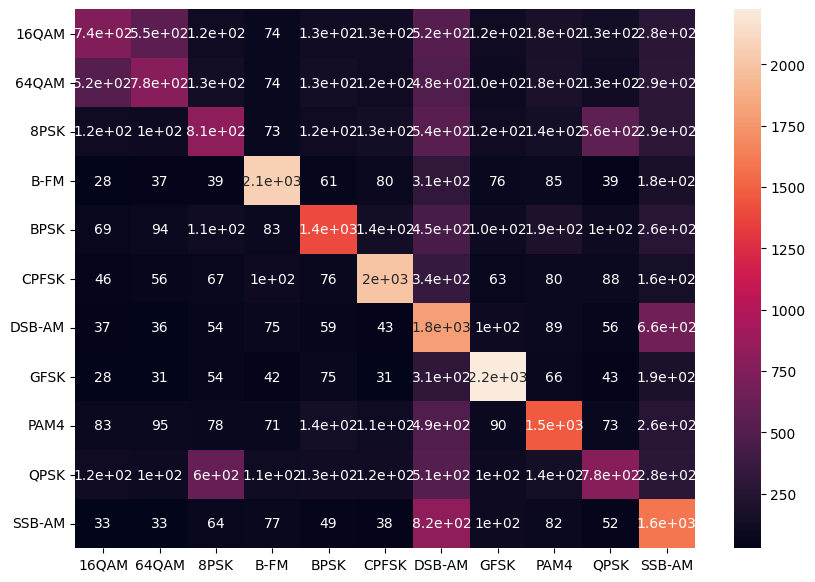

In [22]:
evaluate_model(model, validation_data, validation_labels, verbose=True)

In [23]:
snr_to_acc = get_snr_to_acc(model, validation_data, validation_labels, validation_indecies, verbose=False)
# snr_to_acc = get_snr_to_acc(model, train_data, train_labels, train_indecies, verbose=False)
# snr_to_acc = get_snr_to_acc(model, test_data, test_labels, test_indecies, verbose=False)


(0.0, 1.0)

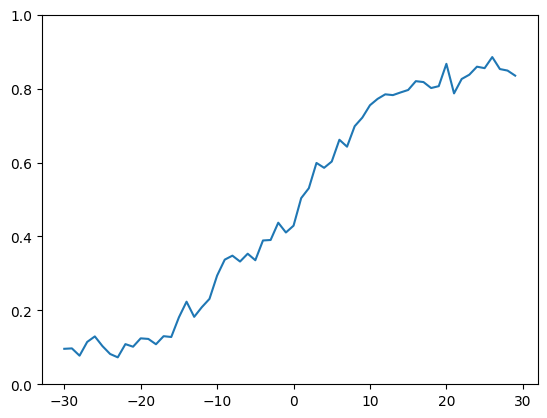

In [24]:
plt.plot(list(snr_to_acc.keys()), list(snr_to_acc.values()))
plt.ylim([0, 1])

In [34]:
len(train_data)

264000